In [8]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
def prepare_data():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    root_dir = "./data/train";
    train_set = datasets.ImageFolder(root = root_dir,

                transform = transforms.ToTensor())

    trainloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)

    root_dir = "./data/test";

    train_set = datasets.ImageFolder(root = root_dir,
                transform = transforms.ToTensor())

    testloader = data.DataLoader(train_set, batch_size = 4, shuffle = True)
    classes = ('Natalie Portman', 'Julia Roberts', 'Neil Patrick Harris'
                    , 'Keifer Sutherland', 'Ben Stiller', 'Anne Hathaway'
                    , 'David Boreanaz', 'Jamie Foxx', 'Sofia Vergara'
                    , 'Elizabeth Banks', 'Jensen Ackles', 'Amy Adams'
                    , 'Kristen Bell', 'Bradley Cooper', 'Emily Deschanel'
                    , 'Zooey Deschanel', 'Jon Hamm', 'Scarlett Johansson'
                    , 'Blake Lively', 'Eva Longoria', 'Amy Poehler'
                    , 'Kristen Stewart', 'Kerry Washington', 'Leighton Meester'
                    , 'Olivia Wilde', 'Zac Efron', 'Miley Cyrus','Jim Parsons')
    return trainloader, testloader, classes
trainloader, testloader, classes = prepare_data()
#
print("train size: " + str(len(trainloader)))
#
print("test size: " + str(len(testloader)))

train size: 2449
test size: 693


torch.Size([4, 3, 250, 250])
Eva Longoria


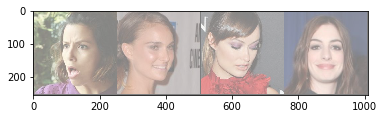

In [9]:
trainloader, testloader, classes = prepare_data()

import matplotlib.pyplot as plt
import numpy as np


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def prepare_and_init_Net(number_layers_1, number_layers_2, number_layers_3):
    class Net(nn.Module):
        def __init__(self, device):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 11)
            self.conv2 = nn.Conv2d(6, 12, 9)
            self.conv3 = nn.Conv2d(12, 24, 7)
            self.conv4 = nn.Conv2d(24, 30, 6)
            self.pool2 = nn.MaxPool2d(2, 2)
            # self.pool3 = nn.MaxPool2d(3,3)
            self.fc1 = nn.Linear(30 * 10 * 10, 240)       #coś tu się dzieje, nie jestem pewnien co
            self.fc2 = nn.Linear(240, 120)
            self.fc3 = nn.Linear(120, 28)

        def forward(self, x):
            # print(x.shape)
            x = self.pool2(F.relu(self.conv1(x)))
            # print(x.shape)
            x = self.pool2(F.relu(self.conv2(x)))

            x = self.pool2(F.relu(self.conv3(x)))
            x = self.pool2(F.relu(self.conv4(x)))
            # print(x.shape)
            # print("to tu?")
            x = x.view(-1, 30 * 10 * 10)
            # print(x.shape)
            x = F.relu(self.fc1(x))
            # print(x.shape)
            x = F.relu(self.fc2(x))
            # print(x.shape)
            x = self.fc3(x)
            # print(x.shape)
            return x


    net = Net(device='cuda:0')
    return net
# print(net.parameters())

In [11]:
import torch.optim as optim

net = prepare_and_init_Net(6, 12, 24)

def crit_and_opt(learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    return criterion, optimizer

In [12]:
def cuda_init():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device
# Assuming that we are on a CUDA machine, this should print a CUDA device:


In [13]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
def accuracy(device, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 2772 test images: %f %%' % (
        100 * correct / total))
        return 100 * correct / total


In [17]:
def learn(device, trainloader, testloader, optimizer, criterion):
    running_loss_for_optimizer = 0.0
    running_loss = 0.0
    loss_for_optimizer = 1.0
    learning_rate = 0.001
    counter=0
    for epoch in range(15):  # loop over the dataset multiple times


        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_loss_for_optimizer += loss.item()
            if i % 1000 == 999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
        print("running loss at end of epoch: ", running_loss_for_optimizer/len(trainloader))
        if(accuracy(device, testloader) > 75):
            break
        if(running_loss_for_optimizer/len(trainloader) < loss_for_optimizer):
            learning_rate /= 2
            loss_for_optimizer /= 2
            criterion, optimizer = crit_and_opt(learning_rate)
            print( "devaluating optimizer, current value: ", loss_for_optimizer)
        running_loss_for_optimizer = 0.0
        running_loss = 0.0


    print('Finished Training')

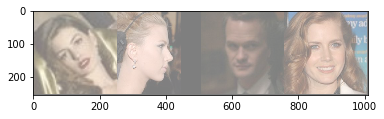

GroundTruth:  Anne Hathaway Scarlett Johansson Neil Patrick Harris Amy Adams


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
trainloader, testloader, classes = prepare_data()
device = cuda_init()
net = prepare_and_init_Net(6, 12, 24)
criterion, optimizer = crit_and_opt(0.001)
learn(device, trainloader, testloader, optimizer, criterion)


[1,  1000] loss: 3.333
[1,  2000] loss: 3.334
running loss at end of epoch:  3.3338789576752035
Accuracy of the network on the 2772 test images: 3.427128 %
[2,  1000] loss: 3.333
[2,  2000] loss: 3.333
running loss at end of epoch:  3.3330981483163518
Accuracy of the network on the 2772 test images: 4.942280 %
[3,  1000] loss: 3.324
[3,  2000] loss: 3.137
running loss at end of epoch:  3.161060254736402
Accuracy of the network on the 2772 test images: 17.712843 %
[4,  1000] loss: 2.546
[4,  2000] loss: 2.213
running loss at end of epoch:  2.3071322710526725
Accuracy of the network on the 2772 test images: 41.233766 %
[5,  1000] loss: 1.716
[5,  2000] loss: 1.597
running loss at end of epoch:  1.6163126437846083
Accuracy of the network on the 2772 test images: 52.128427 %
[6,  1000] loss: 1.216
[6,  2000] loss: 1.213
running loss at end of epoch:  1.2100376825568238
Accuracy of the network on the 2772 test images: 61.363636 %
[7,  1000] loss: 0.881
[7,  2000] loss: 0.929
running loss at

Przed przejrzeniem danych
[1,  1000] loss: 3.334
[1,  2000] loss: 3.334
Accuracy of the network on the 2772 test images: 3.860029 %
[2,  1000] loss: 3.281
[2,  2000] loss: 3.048
Accuracy of the network on the 2772 test images: 25.901876 %
[3,  1000] loss: 2.434
[3,  2000] loss: 2.124
Accuracy of the network on the 2772 test images: 47.799423 %
[4,  1000] loss: 1.649
[4,  2000] loss: 1.581
Accuracy of the network on the 2772 test images: 58.874459 %
[5,  1000] loss: 1.285
[5,  2000] loss: 1.246
Accuracy of the network on the 2772 test images: 52.597403 %
[6,  1000] loss: 1.003
[6,  2000] loss: 1.019
Accuracy of the network on the 2772 test images: 61.976912 %
[7,  1000] loss: 0.775
[7,  2000] loss: 0.869
Accuracy of the network on the 2772 test images: 60.714286 %
[8,  1000] loss: 0.709
[8,  2000] loss: 0.723
Accuracy of the network on the 2772 test images: 57.359307 %
[9,  1000] loss: 0.592
[9,  2000] loss: 0.657
Accuracy of the network on the 2772 test images: 62.229437 %
[10,  1000] loss: 0.607
[10,  2000] loss: 0.617


Po przejrzeniu danych pierwszym:

[1,  1000] loss: 3.334
[1,  2000] loss: 3.332
Accuracy of the network on the 2772 test images: 4.004329 %
[2,  1000] loss: 3.199
[2,  2000] loss: 2.879
Accuracy of the network on the 2772 test images: 31.854257 %
[3,  1000] loss: 2.285
[3,  2000] loss: 2.050
Accuracy of the network on the 2772 test images: 47.005772 %
[4,  1000] loss: 1.692
[4,  2000] loss: 1.549
Accuracy of the network on the 2772 test images: 58.549784 %
[5,  1000] loss: 1.263
[5,  2000] loss: 1.251
Accuracy of the network on the 2772 test images: 61.219336 %
[6,  1000] loss: 1.066
[6,  2000] loss: 1.031
Accuracy of the network on the 2772 test images: 60.966811 %
[7,  1000] loss: 0.901
[7,  2000] loss: 0.931
Accuracy of the network on the 2772 test images: 61.868687 %
[8,  1000] loss: 0.782
[8,  2000] loss: 0.769
Accuracy of the network on the 2772 test images: 63.419913 %
[9,  1000] loss: 0.583
[9,  2000] loss: 0.785
Accuracy of the network on the 2772 test images: 63.059163 %
[10,  1000] loss: 0.677
[10,  2000] loss: 0.668
Accuracy of the network on the 2772 test images: 61.147186 %

Po drugim przejrzeniu:

[1,  1000] loss: 3.333
[1,  2000] loss: 3.333
Accuracy of the network on the 2772 test images: 8.297258 %
[2,  1000] loss: 3.204
[2,  2000] loss: 2.940
Accuracy of the network on the 2772 test images: 26.298701 %
[3,  1000] loss: 2.363
[3,  2000] loss: 2.119
Accuracy of the network on the 2772 test images: 43.398268 %
[4,  1000] loss: 1.743
[4,  2000] loss: 1.643
Accuracy of the network on the 2772 test images: 51.659452 %
[5,  1000] loss: 1.242
[5,  2000] loss: 1.305
Accuracy of the network on the 2772 test images: 60.461760 %
[6,  1000] loss: 1.026
[6,  2000] loss: 1.091
Accuracy of the network on the 2772 test images: 61.255411 %
[7,  1000] loss: 0.806
[7,  2000] loss: 0.907
Accuracy of the network on the 2772 test images: 63.311688 %
[8,  1000] loss: 0.722
[8,  2000] loss: 0.755
Accuracy of the network on the 2772 test images: 57.792208 %
[9,  1000] loss: 0.685
[9,  2000] loss: 0.655
Accuracy of the network on the 2772 test images: 63.492063 %
[10,  1000] loss: 0.547
[10,  2000] loss: 0.628
Accuracy of the network on the 2772 test images: 64.790765 %
Finished Training

learning rate = 0,0004
[1,  1000] loss: 3.334
[1,  2000] loss: 3.332
Accuracy of the network on the 2772 test images: 4.256854 %
[2,  1000] loss: 3.330
[2,  2000] loss: 3.300
Accuracy of the network on the 2772 test images: 11.616162 %
[3,  1000] loss: 2.952
[3,  2000] loss: 2.694
Accuracy of the network on the 2772 test images: 26.984127 %
[4,  1000] loss: 2.215
[4,  2000] loss: 1.962
Accuracy of the network on the 2772 test images: 43.867244 %
[5,  1000] loss: 1.551
[5,  2000] loss: 1.487
Accuracy of the network on the 2772 test images: 59.848485 %
[6,  1000] loss: 1.160
[6,  2000] loss: 1.122
Accuracy of the network on the 2772 test images: 60.028860 %
[7,  1000] loss: 0.861
[7,  2000] loss: 0.869
Accuracy of the network on the 2772 test images: 65.909091 %
[8,  1000] loss: 0.601
[8,  2000] loss: 0.659
Accuracy of the network on the 2772 test images: 63.816739 %
[9,  1000] loss: 0.415
[9,  2000] loss: 0.469
Accuracy of the network on the 2772 test images: 66.883117 %
[10,  1000] loss: 0.323
[10,  2000] loss: 0.393
Accuracy of the network on the 2772 test images: 66.089466 %
Finished Training
